                 ____       __       _                 __   ______            _ __      __     __
                / __ \___  / /______(_)__ _   ______ _/ /  / ____/___  ____  (_) /___  / /_   / /
               / /_/ / _ \/ __/ ___/ / _ \ | / / __ `/ /  / /   / __ \/ __ \/ / / __ \/ __/  / / 
              / _, _/  __/ /_/ /  / /  __/ |/ / /_/ / /  / /___/ /_/ / /_/ / / / /_/ / /_   /_/  
             /_/ |_|\___/\__/_/  /_/\___/|___/\__,_/_/   \____/\____/ .___/_/_/\____/\__/  (_)   
                                                                   /_/                           
                                       (learning every nanosecond)

## Getting code
The goal of this algorithm is to retrieve a relevant code snippet given an English description and a series of already defined code/description pairs.
![ret](../images/retrievalHighLevel.png)

In [1]:
import linecache
import pyndri
import os
import sys
import re
import numpy as np
np.random.seed(0)
import re, string, timeit
from colored import fg, bg, attr
from tensor2tensor.utils import bleu_hook
from multiprocessing import Process, Manager, Pool
import multiprocessing
import copy
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Indri 
Indri is the retrieval engine that I am currently using since it has a nice interface with python and has some of the algorithms I need.

Indri takes files in an XML format. Sentence pairs are usually stored line by line in a file. So we will need to convert from single line to formatted XML.

### Datasets 
We will currently make a full explanation for only one dataset: Django. This is because it is relatively small (18k sentences) and clean. Further descriptions and analysis are found in other notebooks in this directory.

In [2]:
def show_sample(fp, src_ext=".src", tgt_ext=".tgt", lines=[3,21,80,99]):
    linecache.clearcache()
    for l in lines:
        print("LINE: {} \nSOURCE:    {} \nTARGET:     {}\n".format(l, 
                                                                   linecache.getline(fp+src_ext, l), 
                                                                   linecache.getline(fp+tgt_ext, l)))

In [3]:
django_fp = "../datasets/django/all"
show_sample(django_fp, src_ext=".desc", tgt_ext=".code", lines=[13,14])

LINE: 13 
SOURCE:      define the function get_cache with backend and dictionary pair of elements kwargs as arguments.
 
TARGET:         def get_cache ( backend , ** kwargs ) :


LINE: 14 
SOURCE:      call the function warnings.warn with string "'get_cache' is deprecated in favor of 'caches'.", RemovedInDjango19Warning,
 
TARGET:      warnings . warn ( "'get_cache' is deprecated in favor of 'caches'." ,  RemovedInDjango19Warning , stacklevel = 2 )




In [4]:
!head -5 ../datasets/django/all.desc 

  from threading import local into default name space.
  import module warnings.
  from django.conf import settings into default name space.
  from django.core import signals into default name space.
  from django.core.cache.backends.base import InvalidCacheBackendError, CacheKeyWarning and BaseCache into default name space.


In [5]:
!head -5 ../datasets/django/all.code

 from threading import local
 import warnings
  from django . conf import settings
 from django . core import signals
 from django . core . cache . backends . base import (  InvalidCacheBackendError , CacheKeyWarning , BaseCache )


In [6]:
dirName = "temp"
 
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  temp  Created 


### Dataset and train / test split
Copy the full dataset to the temp folder. We then split the data into a training and testing set at around 90% / 10%

In [7]:
train_ratio = 0.9 # this means 90% of the data will be used for training, thus 10% for testing
num_samples = sum(1 for line in open(django_fp + ".desc"))
train_cutoff = int(num_samples * train_ratio)

line_nums = np.arange(num_samples)
np.random.shuffle(line_nums)

train_lines = line_nums[:train_cutoff]
test_lines = line_nums[train_cutoff:]

In [8]:
train_fp = "temp/retrieval_train"
test_fp = "temp/retrieval_test"

##### Train split for .desc and .code

In [9]:
with open(train_fp + ".desc", "w") as out:
    for l in train_lines:
        src = linecache.getline(django_fp + ".desc", l)
        out.write(src)

In [10]:
with open(train_fp + ".code", "w") as out:
    for l in train_lines:
        src = linecache.getline(django_fp + ".code", l)
        out.write(src)

##### Test split for .desc and .code

In [11]:
with open(test_fp + ".desc", "w") as out:
    for l in test_lines:
        src = linecache.getline(django_fp + ".desc", l)
        out.write(src)

In [12]:
with open(test_fp + ".code", "w") as out:
    for l in test_lines:
        src = linecache.getline(django_fp + ".code", l)
        out.write(src)

### Convert to TrecText format

In [13]:
with open(train_fp + ".desc", "r") as f, open("temp/train_desc.trectext", "w") as out:
    count = 0
    while True:
        line = f.readline()
        
        if not line :
            break
            
        out.write("<DOC>\n  <DOCNO>{}</DOCNO>\n  <TEXT>\n{}  </TEXT>\n</DOC>\n".format(count, line))
        count += 1

### Create the index with indri
To create an index we need to supply Indri with a parameter file specifying how to handle each document. Indri will then generate an index folder with is fast to query.

In [99]:
with open("temp/IndriBuildIndex.conf", "w") as out:
    conf = """
<parameters>
<index>temp/django_index/</index>
<memory>1024M</memory>
<storeDocs>true</storeDocs>
<corpus><path>temp/train_desc.trectext</path><class>trectext</class></corpus>
<stemmer><name>krovetz</name></stemmer>
</parameters>"""
    
    out.write(conf)
    

In [100]:
!IndriBuildIndex temp/IndriBuildIndex.conf

kstem_add_table_entry: Duplicate word emeritus will be ignored.
kstem_add_table_entry: Duplicate word emeritus will be ignored.
0:00: Opened repository temp/django_index/
0:00: Opened temp/train_desc.trectext
0:00: Documents parsed: 16928 Documents indexed: 0
0:00: Closed temp/train_desc.trectext
0:00: Closing index
0:00: Finished


In [101]:
index = pyndri.Index("temp/django_index/")
env = pyndri.TFIDFQueryEnvironment(index, k1=1.2, b=0.75)

## Query example

In [106]:
results = env.query('split a string', results_requested=5)

In [107]:
show_sample(train_fp, src_ext=".desc", tgt_ext=".code", lines=[doc[0] for doc in results])

LINE: 4535 
SOURCE:      return split.
 
TARGET:       return split


LINE: 7891 
SOURCE:      append bit to split.
 
TARGET:       split . append ( bit )


LINE: 14712 
SOURCE:      split is an empty list.
 
TARGET:               split = [ ]


LINE: 3402 
SOURCE:      join elements of quant into a string, split it by string ',', substitute the result for values.
 
TARGET:      values = '' . join ( quant ) . split ( ',' )


LINE: 8654 
SOURCE:      if extra_classes has an attribute 'split',
 
TARGET:      if hasattr ( extra_classes , 'split' ) :




In [19]:
top_code = [linecache.getline(django_fp + ".code", doc[0]) for doc in results]

We need to remove punctuation from input query strings so that Indri accepts them.

In [9]:
pattern = re.compile(r'[^\w\s]')

In [21]:
linecache.clearcache()
with open(test_fp + ".desc", "r") as f, open("temp/retrieval_predictions" + ".code", "w") as out:
    lines = f.readlines()
    l = 1
    for line in lines:
        result = env.query(pattern.sub(" ", line), results_requested=1)
        if result != ():
            out.write(linecache.getline(train_fp + ".code",result[0][0]))
        else:
            out.write("\n")
            print("LINE: {} \n{}{}QUERY:{}    {}\nSANITIZED QUERY      {}\n{}{}PRED DESCRIPTION{}:   ######### NO PREDICTION ##########\n".format(
                l, 
                fg(24), 
                bg(85),
                attr(0),
                line,
                fg(24), 
                bg(217),
                attr(0),
                line.translate(str.maketrans('', '', string.punctuation))))
        if l % 500 == 1:
            print("LINE: {} \n{}{}QUERY:{}    {}\n{}{}PRED DESCRIPTION:{}    {} \n{}{}PRED CODE:{}     {}\n{}{}TRUTH:{}    {}\n".format(
                l, 
                fg(24), 
                bg(85),
                attr(0),
                line, 
                fg(24), 
                bg(153),
                attr(0),
                linecache.getline(train_fp + ".desc", result[0][0]), 
                fg(24), 
                bg(153),
                attr(0),
                linecache.getline(train_fp + ".code", result[0][0]),
                fg(24), 
                bg(85),
                attr(0),
                linecache.getline(test_fp + ".code", l)))
        l += 1

LINE: 1 
QUERY:      raise a ValidationError exception with 2 arguments: return value of the function _ called with an argument string 'Enter a valid IPv6 address.', and code set to string 'invalid'.

PRED DESCRIPTION:      raise a ValidationError exception with 2 arguments: return value of the function _ called with an argument string 'Enter a valid IPv4 or IPv6 address.', and code set to string 'invalid'.
 
PRED CODE:                   raise ValidationError ( _ ( 'Enter a valid IPv4 or IPv6 address.' ) , code = 'invalid' )

TRUTH:              raise ValidationError ( _ ( 'Enter a valid IPv6 address.' ) , code = 'invalid' )


LINE: 501 
QUERY:      convert max_entries into a string, substitute it for self._max_entries.

PRED DESCRIPTION:      convert self into a string and return it.
 
PRED CODE:               return str ( self )

TRUTH:                  self . _max_entries = int ( max_entries )


LINE: 1001 
QUERY:      define the method add with 5 arguments, self class instance, key

### Calculating BLEU Score
We use a librarry from Google's tensor2tensor library. This way we ensure the methods are correct by being actively maintained. The method takes two files and compares them line by line.

The only disadvantage is that it doesn't work with TF2.0 yet. Curently using TF1.14.0

In [22]:
bleu = 100 * bleu_hook.bleu_wrapper("temp/retrieval_test.code", "temp/retrieval_predictions.code",
                                          case_sensitive=False)
print("BLEU_uncased = %6.2f" % bleu)

W0814 10:54:47.696853 139956174415616 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



BLEU_uncased =  37.13


## Multiprocessing
In order to make fast optimisations we will use a multiprocessing library to fully utilise our hardware.

In [51]:
uid = 0

In [52]:
base_task = {
        "job_id":0,
        "train_fp":"temp/retrieval_train",
        "test_fp":"temp/retrieval_test",
        "src_ext":".desc",
        "tgt_ext":".code",
        "hyps":{
            "b":0.75,
            "k1":1.2
        },
#         "env":pyndri.TFIDFQueryEnvironment(index, k1=1.2, b=0.75),
        "folds":1,
        "fold":1
    }

In [19]:
def TFIDF_task_generator(task, k1s=[1.0, 1.5, 2.0], bs=[0.0,0.25,0.5,0.75,1.0]):
    global uid
    tasks = [] 
    for k1 in k1s:
        for b in bs:
            new_task = dict(task)
            new_task["hyps"] = {"b":b, "k1":k1}
#             new_task["env"] = pyndri.TFIDFQueryEnvironment(index, k1=k1, b=b)
            new_task["job_id"] = uid
            uid += 1
            tasks.append(new_task)
    return tasks

In [20]:
def TFIDF_random_task_generator(task, samples, k1s=(1.0,2.0), bs=(0.0, 1.0)):
    global uid
    tasks = [] 
    for s in range(samples):
        b = np.random.uniform(bs[0], bs[1])
        k1 = np.random.uniform(k1s[0], k1s[1])
        new_task = dict(task)
        new_task["hyps"] = {"b":b, "k1":k1}
#         new_task["env"] = pyndri.TFIDFQueryEnvironment(index, k1=k1, b=b)
        new_task["job_id"] = uid
        uid += 1
        tasks.append(new_task)
    return tasks

In [53]:
def OKAPI_random_task_generator(task, samples, k1s=(1.0,2.0), k3s=(1.0,2.0), bs=(0.0, 1.0)):
    global uid
    tasks = [] 
    for s in range(samples):
        b = np.random.uniform(bs[0], bs[1])
        k1 = np.random.uniform(k1s[0], k1s[1])
        k3 = np.random.uniform(k3s[0], k3s[1])
        new_task = dict(task)
        new_task["hyps"] = {"b":b, "k1":k1, "k3":k3}
#         new_task["env"] = pyndri.TFIDFQueryEnvironment(index, k1=k1, b=b)
        new_task["job_id"] = uid
        uid += 1
        tasks.append(new_task)
    return tasks

In [58]:
tasks = []

In [59]:
# tasks += TFIDF_random_task_generator(base_task, 20, k1s=(0.5,1.3), bs=(0.5, 1.3))
tasks += OKAPI_random_task_generator(base_task, 10, k1s=(0.5,1.3), k3s=(0.0,2.0), bs=(0.5, 1.3))

In [60]:
tasks

[{'fold': 1,
  'folds': 1,
  'hyps': {'b': 1.2650077215070887,
   'k1': 0.9040607218400287,
   'k3': 1.3143363019272427},
  'job_id': 30,
  'src_ext': '.desc',
  'test_fp': 'temp/retrieval_test',
  'tgt_ext': '.code',
  'train_fp': 'temp/retrieval_train'},
 {'fold': 1,
  'folds': 1,
  'hyps': {'b': 0.7595408732858537,
   'k1': 0.8047703293657308,
   'k3': 0.9663272626680919},
  'job_id': 31,
  'src_ext': '.desc',
  'test_fp': 'temp/retrieval_test',
  'tgt_ext': '.code',
  'train_fp': 'temp/retrieval_train'},
 {'fold': 1,
  'folds': 1,
  'hyps': {'b': 0.7735643202049118,
   'k1': 0.7693911379017464,
   'k3': 0.10919183932247467},
  'job_id': 32,
  'src_ext': '.desc',
  'test_fp': 'temp/retrieval_test',
  'tgt_ext': '.code',
  'train_fp': 'temp/retrieval_train'},
 {'fold': 1,
  'folds': 1,
  'hyps': {'b': 0.9439937698309604,
   'k1': 0.5155755650717541,
   'k3': 1.7066304896269786},
  'job_id': 33,
  'src_ext': '.desc',
  'test_fp': 'temp/retrieval_test',
  'tgt_ext': '.code',
  'train_f

In [61]:
def train_eval(task, index):
    print(task["hyps"], task["job_id"])
    linecache.clearcache()
#     env = pyndri.TFIDFQueryEnvironment(index, k1=task["hyps"]["k1"], b=task["hyps"]["b"])
    env = pyndri.OkapiQueryEnvironment(index, k1=task["hyps"]["k1"], b=task["hyps"]["b"])
    
    out_file_name = "temp/retrieval_predictions_fold:{}-{}_k1_{}_b_{}".format(
                                                                            task["fold"],
                                                                            task["folds"],
                                                                            task["hyps"]["k1"],
                                                                            task["hyps"]["b"])
    with open(task["test_fp"] + ".desc", "r") as f, open(out_file_name + ".code", "w") as out:
        lines = f.readlines()
        for line in lines:
            result = env.query(pattern.sub(" ", line), results_requested=1)
            if result != ():
                out.write(linecache.getline(task["train_fp"] + ".code",result[0][0]))
            else:
                out.write("\n")
                
    bleu = 100 * bleu_hook.bleu_wrapper(task["test_fp"] + ".code", out_file_name + ".code",
                                          case_sensitive=False)
                
    task["BLEU"] = bleu
    measures.append(task)
    print("Task Completed: {}".format(task["job_id"]))

In [62]:
with Manager() as manager:
    measures = manager.list()
    processes = []
    for task in tasks:
        p = Process(target=train_eval, args=(task, index))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()
        print(p)
    measures = list(measures)

{'k3': 1.3143363019272427, 'k1': 0.9040607218400287, 'b': 1.2650077215070887} 30
{'k3': 0.9663272626680919, 'k1': 0.8047703293657308, 'b': 0.7595408732858537} 31
{'k3': 0.10919183932247467, 'k1': 0.7693911379017464, 'b': 0.7735643202049118} 32
{'k3': 1.7066304896269786, 'k1': 0.5155755650717541, 'b': 0.9439937698309604} 33
{'k3': 0.27170873485549096, 'k1': 1.0744833819603885, 'b': 0.8939988399130052} 35
{'k3': 0.07455625281104417, 'k1': 1.0855161512612275, 'b': 0.713322150659002} 34
{'k3': 1.683234339459596, 'k1': 0.887397974252266, 'b': 1.2077728499030558} 36
{'k3': 0.31576955930984996, 'k1': 0.8222361749009833, 'b': 0.6285123667608327} 37
{'k3': 0.9636138129242457, 'k1': 0.7459826250784641, 'b': 0.9326762733792326} 38
{'k3': 1.4038003313828382, 'k1': 0.8480531685726671, 'b': 0.9547506060342614} 39


W0814 16:26:38.208891 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:26:38.257460 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:26:38.385710 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:26:38.404399 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:26:38.449324 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist

Task Completed: 31
Task Completed: 32
Task Completed: 39
Task Completed: 30
Task Completed: 38
Task Completed: 33
Task Completed: 36
Task Completed: 35
Task Completed: 34
Task Completed: 37
<Process(Process-1013, stopped)>
<Process(Process-1014, stopped)>
<Process(Process-1015, stopped)>
<Process(Process-1016, stopped)>
<Process(Process-1017, stopped)>
<Process(Process-1018, stopped)>
<Process(Process-1019, stopped)>
<Process(Process-1020, stopped)>
<Process(Process-1021, stopped)>
<Process(Process-1022, stopped)>


In [63]:
print([m["job_id"] for m in measures])
print()
print([(m["hyps"], m["BLEU"]) for m in measures])
print()
print(len(measures))

[31, 32, 39, 30, 38, 33, 36, 35, 34, 37]

[({'k3': 0.9663272626680919, 'k1': 0.8047703293657308, 'b': 0.7595408732858537}, 42.24500060081482), ({'k3': 0.10919183932247467, 'k1': 0.7693911379017464, 'b': 0.7735643202049118}, 42.16753840446472), ({'k3': 1.4038003313828382, 'k1': 0.8480531685726671, 'b': 0.9547506060342614}, 41.59160554409027), ({'k3': 1.3143363019272427, 'k1': 0.9040607218400287, 'b': 1.2650077215070887}, 39.09807205200195), ({'k3': 0.9636138129242457, 'k1': 0.7459826250784641, 'b': 0.9326762733792326}, 42.073291540145874), ({'k3': 1.7066304896269786, 'k1': 0.5155755650717541, 'b': 0.9439937698309604}, 42.19968318939209), ({'k3': 1.683234339459596, 'k1': 0.887397974252266, 'b': 1.2077728499030558}, 39.63049054145813), ({'k3': 0.27170873485549096, 'k1': 1.0744833819603885, 'b': 0.8939988399130052}, 41.543254256248474), ({'k3': 0.07455625281104417, 'k1': 1.0855161512612275, 'b': 0.713322150659002}, 42.204612493515015), ({'k3': 0.31576955930984996, 'k1': 0.8222361749009833,

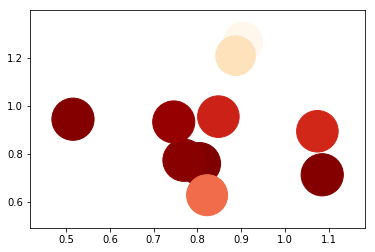

In [64]:
x = [m["hyps"]["k1"] for m in measures]
y = [m["hyps"]["b"] for m in measures]
s = [m["BLEU"]**2 for m in measures]

plt.scatter(x, y, s=s, c=s, alpha=1, cmap="OrRd")
plt.show()

In [65]:
measures[np.argmax([m["BLEU"]**2 for m in measures])]

{'BLEU': 42.24500060081482,
 'fold': 1,
 'folds': 1,
 'hyps': {'b': 0.7595408732858537,
  'k1': 0.8047703293657308,
  'k3': 0.9663272626680919},
 'job_id': 31,
 'src_ext': '.desc',
 'test_fp': 'temp/retrieval_test',
 'tgt_ext': '.code',
 'train_fp': 'temp/retrieval_train'}

## K-Fold cross validation and hyperparameter tuning

In [66]:
line_nums

array([ 7221,  6338,  9923, ...,  9845, 10799,  2732])

In [67]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

In [68]:
def create_train_test_files(fold_num, num_folds, line_nums):
    fold_size = (len(line_nums)//num_folds) + 1

    fold_line_nums = list(chunks(line_nums, fold_size))
    
    train_lines = []
    for i in range(len(fold_line_nums)):
        if i+1 == fold_num:
            test_lines = fold_line_nums[i]
        else:
            train_lines += list(fold_line_nums[i])
            
    # Now file manipulation
    linecache.clearcache()
    with open(train_fp + ".desc", "w") as out:
        for l in train_lines:
            src = linecache.getline(django_fp + ".desc", l)
            out.write(src)
            
    with open(train_fp + ".code", "w") as out:
        for l in train_lines:
            src = linecache.getline(django_fp + ".code", l)
            out.write(src)
            
    with open(test_fp + ".desc", "w") as out:
        for l in test_lines:
            src = linecache.getline(django_fp + ".desc", l)
            out.write(src)
    with open(test_fp + ".code", "w") as out:
        for l in test_lines:
            src = linecache.getline(django_fp + ".code", l)
            out.write(src)

This creates a train and test set of files from a particular fold of the dataset.

In [69]:
create_train_test_files(2, 6, line_nums)

In [70]:
with open("temp/IndriBuildIndex.conf", "w") as out:
    conf = """
<parameters>
<index>temp/django_index/</index>
<memory>1024M</memory>
<storeDocs>true</storeDocs>
<corpus><path>temp/train_desc.trectext</path><class>trectext</class></corpus>
<stemmer><name>krovetz</name></stemmer>
</parameters>"""
    
    out.write(conf)

In [71]:
def train_to_trectext():
    with open(train_fp + ".desc", "r") as f, open("temp/train_desc.trectext", "w") as out:
        count = 0
        while True:
            line = f.readline()

            if not line :
                break

            out.write("<DOC>\n  <DOCNO>{}</DOCNO>\n  <TEXT>\n{}  </TEXT>\n</DOC>\n".format(count, line))
            count += 1

In [73]:
tasks = []
# tasks += TFIDF_random_task_generator(base_task, 100, k1s=(0.0,1.2), bs=(0.0, 2.0))
tasks += OKAPI_random_task_generator(base_task, 100, k1s=(0.0,1.2), k3s=(0.0,2.0), bs=(0.0, 2.3))

In [74]:
per_fold_measures = []

In [75]:
num_folds = 10
for i in range(num_folds):
    create_train_test_files(i+1, num_folds, line_nums)
    train_to_trectext()
    
    !rm -rf temp/django_index
    !IndriBuildIndex temp/IndriBuildIndex.conf
    index = pyndri.Index("temp/django_index/")
    
    with Manager() as manager:
        measures = manager.list()
        processes = []
        for task in tasks:
            p = Process(target=train_eval, args=(task, index))
            p.start()
            processes.append(p)
        for p in processes:
            p.join()
            print(p)
        measures = list(measures)
    per_fold_measures.append(measures)

kstem_add_table_entry: Duplicate word emeritus will be ignored.
0:00: Created repository temp/django_index/
0:00: Opened temp/train_desc.trectext
0:09: Documents parsed: 16923 Documents indexed: 16923
0:09: Closed temp/train_desc.trectext
0:09: Closing index
0:09: Finished
{'k3': 0.5905300654683296, 'k1': 0.8179659186653743, 'b': 2.0314368537488976} 140
{'k3': 0.979926257648845, 'k1': 0.8384954453862125, 'b': 1.2956274309436513} 141
{'k3': 1.1170500301850437, 'k1': 0.19677445190041523, 'b': 1.05925878800152} 142
{'k3': 1.2808935851200074, 'k1': 1.1913488806486114, 'b': 1.7911862785527861} 143
{'k3': 1.0418770307367122, 'k1': 0.5102716955636952, 'b': 1.5310919868830293} 144
{'k3': 0.13657410567354544, 'k1': 1.1561756568048707, 'b': 0.6072115694978384} 146
{'k3': 0.36907111871683873, 'k1': 0.5046938182792853, 'b': 0.31714897796988856} 147
{'k3': 0.6773811803333942, 'k1': 0.06940353925286766, 'b': 1.5930248036046457} 145
{'k3': 0.782103370238145, 'k1': 0.896878229756698, 'b': 1.4089170326

{'k3': 1.8226227446600436, 'k1': 0.6151815563248684, 'b': 2.1245190010513397} 237
{'k3': 0.23668294026642922, 'k1': 1.1865337179698607, 'b': 1.1275688798503598} 238
{'k3': 1.7175958774529665, 'k1': 1.0511764530009262, 'b': 1.55872581200904} 239


W0814 16:32:38.458929 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:32:39.338158 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:32:37.263071 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:32:42.009254 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:32:43.067684 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist

W0814 16:32:57.758792 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 16:32:57.819021 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:32:57.980315 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:32:58.507670 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:32:59.148409 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis


W0814 16:33:05.383907 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:33:05.626364 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:33:05.648778 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:33:06.000338 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:33:06.444576 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis

Task Completed: 150



W0814 16:33:07.755566 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:33:07.793538 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:33:08.225380 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:33:08.343014 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 16:33:08.333905 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist

Task Completed: 158
Task Completed: 149


W0814 16:33:15.665301 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



Task Completed: 142
Task Completed: 153
Task Completed: 155
Task Completed: 147
Task Completed: 162
Task Completed: 144
Task Completed: 141
Task Completed: 161
Task Completed: 160
Task Completed: 156
Task Completed: 186
Task Completed: 159
Task Completed: 143
Task Completed: 164
Task Completed: 209
Task Completed: 185
Task Completed: 151
Task Completed: 140
Task Completed: 163
<Process(Process-1024, stopped)>
<Process(Process-1025, stopped)>
<Process(Process-1026, stopped)>
<Process(Process-1027, stopped)>
<Process(Process-1028, stopped)>
Task Completed: 154
Task Completed: 205
Task Completed: 169
Task Completed: 168
Task Completed: 190
Task Completed: 166
Task Completed: 148
Task Completed: 178
Task Completed: 165
Task Completed: 175
Task Completed: 172
Task Completed: 152
Task Completed: 191
Task Completed: 184
Task Completed: 146
Task Completed: 188
Task Completed: 170
Task Completed: 177
Task Completed: 201
Task Completed: 189
Task Completed: 195
Task Completed: 157
Task Completed:

{'k3': 0.85152575407014, 'k1': 0.5491301727363751, 'b': 1.005710415472744} 173
{'k3': 0.9394672261528376, 'k1': 1.170221577637043, 'b': 0.06140934374528297} 174
{'k3': 0.8974719257802544, 'k1': 1.019555814528957, 'b': 0.8030827813930183} 175
{'k3': 1.4175983742965732, 'k1': 0.047623664281178965, 'b': 0.09223989208589344} 176
{'k3': 1.2678177028057733, 'k1': 0.1963284082810491, 'b': 0.13266144022268228} 177
{'k3': 1.5582185360325178, 'k1': 0.28758788189550805, 'b': 0.08574909505931805} 178
{'k3': 1.8170651375762124, 'k1': 0.3248670392985593, 'b': 2.2120789727747026} 179
{'k3': 1.3203581609665034, 'k1': 0.6714433668532235, 'b': 0.6273035408837528} 180
{'k3': 0.14470709223798583, 'k1': 0.6218998382467442, 'b': 2.1691423876869425} 181
{'k3': 0.539301751506454, 'k1': 0.6137293752820892, 'b': 1.5304404410295946} 182
{'k3': 1.311109022883126, 'k1': 0.7509929112331444, 'b': 1.297783093474349} 183
{'k3': 1.2307210432827165, 'k1': 1.047280362347306, 'b': 1.8526602898188942} 184
{'k3': 1.93566185

W0814 16:38:02.432174 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:38:07.781641 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:38:07.842606 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:38:09.555786 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 16:38:09.582470 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-


W0814 16:38:21.021047 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 16:38:21.092285 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:38:21.422610 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:38:21.688350 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:38:21.771599 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/di


W0814 16:38:28.572957 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:38:28.612408 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:38:28.751358 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:38:28.862326 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:38:29.053866 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis


W0814 16:38:34.429038 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 16:38:34.490495 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.




Task Completed: 140


W0814 16:38:34.587218 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



<Process(Process-1125, stopped)>


W0814 16:38:35.069283 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 16:38:35.027313 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 16:38:35.169450 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:38:35.862615 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:38:36.738472 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist

Task Completed: 158
Task Completed: 169
Task Completed: 162
Task Completed: 166
Task Completed: 154
Task Completed: 149
Task Completed: 164
Task Completed: 165
Task Completed: 150
Task Completed: 179
Task Completed: 141
<Process(Process-1126, stopped)>
Task Completed: 184
Task Completed: 175
Task Completed: 143
Task Completed: 170
Task Completed: 167
Task Completed: 198
Task Completed: 152
Task Completed: 190
Task Completed: 182
Task Completed: 151
Task Completed: 209
Task Completed: 191
Task Completed: 156
Task Completed: 173
Task Completed: 159
Task Completed: 142
Task Completed: 144
Task Completed: 172
<Process(Process-1127, stopped)>
<Process(Process-1128, stopped)>
<Process(Process-1129, stopped)>
Task Completed: 238
Task Completed: 183
Task Completed: 148
Task Completed: 224
Task Completed: 186
Task Completed: 145
Task Completed: 188
Task Completed: 187
Task Completed: 219
Task Completed: 146
Task Completed: 194
<Process(Process-1130, stopped)>
Task Completed: 153
Task Completed:

{'k3': 0.85152575407014, 'k1': 0.5491301727363751, 'b': 1.005710415472744} 173
{'k3': 0.9394672261528376, 'k1': 1.170221577637043, 'b': 0.06140934374528297} 174
{'k3': 0.8974719257802544, 'k1': 1.019555814528957, 'b': 0.8030827813930183} 175
{'k3': 1.4175983742965732, 'k1': 0.047623664281178965, 'b': 0.09223989208589344} 176
{'k3': 1.2678177028057733, 'k1': 0.1963284082810491, 'b': 0.13266144022268228} 177
{'k3': 1.5582185360325178, 'k1': 0.28758788189550805, 'b': 0.08574909505931805} 178
{'k3': 1.8170651375762124, 'k1': 0.3248670392985593, 'b': 2.2120789727747026} 179
{'k3': 1.3203581609665034, 'k1': 0.6714433668532235, 'b': 0.6273035408837528} 180
{'k3': 0.14470709223798583, 'k1': 0.6218998382467442, 'b': 2.1691423876869425} 181
{'k3': 0.539301751506454, 'k1': 0.6137293752820892, 'b': 1.5304404410295946} 182
{'k3': 1.311109022883126, 'k1': 0.7509929112331444, 'b': 1.297783093474349} 183
{'k3': 1.2307210432827165, 'k1': 1.047280362347306, 'b': 1.8526602898188942} 184
{'k3': 1.93566185

W0814 16:43:26.178323 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:26.531743 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:30.266653 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:31.720873 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:33.268315 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist



W0814 16:43:42.297478 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:42.546674 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:42.635959 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:42.736645 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:43.161234 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/di


W0814 16:43:48.316504 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 16:43:48.411078 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 16:43:48.636024 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:49.017055 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:49.286412 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis

Task Completed: 143


W0814 16:43:51.915890 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:52.173427 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:52.537185 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:52.766259 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 16:43:52.786631 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-

Task Completed: 188


W0814 16:43:56.469296 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:57.266359 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


Task Completed: 186


Task Completed: 175


W0814 16:43:58.346483 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:43:58.455655 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



Task Completed: 156
Task Completed: 155
Task Completed: 141
Task Completed: 172
Task Completed: 179
Task Completed: 140
Task Completed: 185
<Process(Process-1226, stopped)>
<Process(Process-1227, stopped)>
Task Completed: 146
Task Completed: 166
Task Completed: 194
Task Completed: 183
Task Completed: 154
Task Completed: 165
Task Completed: 173
Task Completed: 152
Task Completed: 171
Task Completed: 221
Task Completed: 145
Task Completed: 150
Task Completed: 192
Task Completed: 151
Task Completed: 163
Task Completed: 148
Task Completed: 167
Task Completed: 149
Task Completed: 144
Task Completed: 153
Task Completed: 177
Task Completed: 158
Task Completed: 160
Task Completed: 182
Task Completed: 209
Task Completed: 157
Task Completed: 220
Task Completed: 184
Task Completed: 147
Task Completed: 191
Task Completed: 142
Task Completed: 198
Task Completed: 224
Task Completed: 181
Task Completed: 206
Task Completed: 174
Task Completed: 168
Task Completed: 219
<Process(Process-1228, stopped)>
<

{'k3': 0.85152575407014, 'k1': 0.5491301727363751, 'b': 1.005710415472744} 173
{'k3': 0.9394672261528376, 'k1': 1.170221577637043, 'b': 0.06140934374528297} 174
{'k3': 0.8974719257802544, 'k1': 1.019555814528957, 'b': 0.8030827813930183} 175
{'k3': 1.4175983742965732, 'k1': 0.047623664281178965, 'b': 0.09223989208589344} 176
{'k3': 1.2678177028057733, 'k1': 0.1963284082810491, 'b': 0.13266144022268228} 177
{'k3': 1.5582185360325178, 'k1': 0.28758788189550805, 'b': 0.08574909505931805} 178
{'k3': 1.8170651375762124, 'k1': 0.3248670392985593, 'b': 2.2120789727747026} 179
{'k3': 1.3203581609665034, 'k1': 0.6714433668532235, 'b': 0.6273035408837528} 180
{'k3': 0.14470709223798583, 'k1': 0.6218998382467442, 'b': 2.1691423876869425} 181
{'k3': 0.539301751506454, 'k1': 0.6137293752820892, 'b': 1.5304404410295946} 182
{'k3': 1.311109022883126, 'k1': 0.7509929112331444, 'b': 1.297783093474349} 183
{'k3': 1.2307210432827165, 'k1': 1.047280362347306, 'b': 1.8526602898188942} 184
{'k3': 1.93566185

W0814 16:48:41.741945 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:48:42.229794 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:48:43.315271 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:48:45.489702 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:48:51.287594 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist



W0814 16:48:58.866939 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:48:58.962473 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:48:59.497485 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:48:59.575978 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:49:00.274516 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/di



W0814 16:49:04.521274 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:49:04.924100 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:49:05.850276 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:49:05.990697 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:49:06.102988 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/di

Task Completed: 149



W0814 16:49:06.536876 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 16:49:06.621469 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 16:49:06.645348 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



W0814 16:49:06.696697 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:49:07.071651 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis

Task Completed: 152


W0814 16:49:13.530949 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



Task Completed: 162


W0814 16:49:14.281339 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:49:14.811337 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:49:15.711266 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



Task Completed: 196
Task Completed: 151
Task Completed: 155
Task Completed: 170
Task Completed: 141
Task Completed: 140
Task Completed: 142
<Process(Process-1327, stopped)>
<Process(Process-1328, stopped)>
Task Completed: 145
<Process(Process-1329, stopped)>
Task Completed: 148
Task Completed: 143
Task Completed: 150
Task Completed: 165
<Process(Process-1330, stopped)>
Task Completed: 168
Task Completed: 159
Task Completed: 183
Task Completed: 153
Task Completed: 144
Task Completed: 201
Task Completed: 166
Task Completed: 189
<Process(Process-1331, stopped)>
<Process(Process-1332, stopped)>
Task Completed: 172
Task Completed: 185
Task Completed: 239
Task Completed: 180
Task Completed: 182
Task Completed: 164
Task Completed: 179
Task Completed: 175
Task Completed: 161
Task Completed: 147
Task Completed: 234
Task Completed: 187
Task Completed: 195
Task Completed: 198
Task Completed: 173
Task Completed: 160
Task Completed: 191
Task Completed: 163
Task Completed: 202
Task Completed: 156
Ta

{'k3': 0.85152575407014, 'k1': 0.5491301727363751, 'b': 1.005710415472744} 173
{'k3': 0.9394672261528376, 'k1': 1.170221577637043, 'b': 0.06140934374528297} 174
{'k3': 0.8974719257802544, 'k1': 1.019555814528957, 'b': 0.8030827813930183} 175
{'k3': 1.4175983742965732, 'k1': 0.047623664281178965, 'b': 0.09223989208589344} 176
{'k3': 1.2678177028057733, 'k1': 0.1963284082810491, 'b': 0.13266144022268228} 177
{'k3': 1.5582185360325178, 'k1': 0.28758788189550805, 'b': 0.08574909505931805} 178
{'k3': 1.8170651375762124, 'k1': 0.3248670392985593, 'b': 2.2120789727747026} 179
{'k3': 1.3203581609665034, 'k1': 0.6714433668532235, 'b': 0.6273035408837528} 180
{'k3': 0.14470709223798583, 'k1': 0.6218998382467442, 'b': 2.1691423876869425} 181
{'k3': 0.539301751506454, 'k1': 0.6137293752820892, 'b': 1.5304404410295946} 182
{'k3': 1.311109022883126, 'k1': 0.7509929112331444, 'b': 1.297783093474349} 183
{'k3': 1.2307210432827165, 'k1': 1.047280362347306, 'b': 1.8526602898188942} 184
{'k3': 1.93566185

W0814 16:54:21.145767 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:54:26.112072 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:54:27.059959 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:54:27.729064 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:54:27.869006 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist

W0814 16:54:33.853784 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 16:54:33.974539 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:54:34.247191 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:54:34.578364 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:54:34.993889 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis


W0814 16:54:40.017028 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:54:40.964720 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:54:41.567041 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 16:54:41.526057 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:54:41.620251 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist

W0814 16:54:46.500649 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 16:54:46.726424 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:54:47.195223 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 16:54:47.248616 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 16:54:47.736190 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis

Task Completed: 143
Task Completed: 141
Task Completed: 156
Task Completed: 166
Task Completed: 140
Task Completed: 151
<Process(Process-1428, stopped)>
<Process(Process-1429, stopped)>
Task Completed: 184
Task Completed: 148
Task Completed: 149
Task Completed: 168
Task Completed: 152
Task Completed: 154
Task Completed: 153
Task Completed: 144
Task Completed: 142
Task Completed: 180
<Process(Process-1430, stopped)>
<Process(Process-1431, stopped)>
<Process(Process-1432, stopped)>
Task Completed: 150
Task Completed: 195
Task Completed: 190
Task Completed: 163
Task Completed: 172
Task Completed: 219
Task Completed: 147
Task Completed: 161
Task Completed: 191
Task Completed: 169
Task Completed: 201
Task Completed: 185
Task Completed: 145
Task Completed: 146
Task Completed: 186
<Process(Process-1433, stopped)>
<Process(Process-1434, stopped)>
<Process(Process-1435, stopped)>
<Process(Process-1436, stopped)>
<Process(Process-1437, stopped)>
<Process(Process-1438, stopped)>
<Process(Process-

{'k3': 1.4255328768721354, 'k1': 0.6536489139027284, 'b': 2.1131345242355217} 172
{'k3': 0.85152575407014, 'k1': 0.5491301727363751, 'b': 1.005710415472744} 173
{'k3': 0.9394672261528376, 'k1': 1.170221577637043, 'b': 0.06140934374528297} 174
{'k3': 0.8974719257802544, 'k1': 1.019555814528957, 'b': 0.8030827813930183} 175
{'k3': 1.4175983742965732, 'k1': 0.047623664281178965, 'b': 0.09223989208589344} 176
{'k3': 1.2678177028057733, 'k1': 0.1963284082810491, 'b': 0.13266144022268228} 177
{'k3': 1.5582185360325178, 'k1': 0.28758788189550805, 'b': 0.08574909505931805} 178
{'k3': 1.8170651375762124, 'k1': 0.3248670392985593, 'b': 2.2120789727747026} 179
{'k3': 1.3203581609665034, 'k1': 0.6714433668532235, 'b': 0.6273035408837528} 180
{'k3': 0.14470709223798583, 'k1': 0.6218998382467442, 'b': 2.1691423876869425} 181
{'k3': 0.539301751506454, 'k1': 0.6137293752820892, 'b': 1.5304404410295946} 182
{'k3': 1.311109022883126, 'k1': 0.7509929112331444, 'b': 1.297783093474349} 183
{'k3': 1.2307210

W0814 16:59:52.552019 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:59:54.515418 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:59:56.433151 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:59:56.532066 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 16:59:58.592933 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist


W0814 17:00:08.155388 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:00:08.579454 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:00:08.624411 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:00:08.611679 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



W0814 17:00:08.919184 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis

W0814 17:00:13.781458 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 17:00:14.518513 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:00:14.999351 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:00:15.019881 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 17:00:15.043088 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis


W0814 17:00:18.821755 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:00:18.990968 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:00:19.322064 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:00:19.629645 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:00:19.731076 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis

Task Completed: 143


W0814 17:00:21.817924 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:00:22.030617 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



Task Completed: 150


W0814 17:00:25.680108 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



Task Completed: 152
Task Completed: 147
Task Completed: 167
Task Completed: 140
Task Completed: 163
Task Completed: 158
Task Completed: 156
<Process(Process-1529, stopped)>
Task Completed: 165
Task Completed: 149
Task Completed: 141
Task Completed: 166
Task Completed: 151
Task Completed: 170
<Process(Process-1530, stopped)>
Task Completed: 148
Task Completed: 184
Task Completed: 172
Task Completed: 164
Task Completed: 168
Task Completed: 144
Task Completed: 183
Task Completed: 180
Task Completed: 195
Task Completed: 175
Task Completed: 190
Task Completed: 224
Task Completed: 173
Task Completed: 142
Task Completed: 159
Task Completed: 154
Task Completed: 153
<Process(Process-1531, stopped)>
<Process(Process-1532, stopped)>
<Process(Process-1533, stopped)>
Task Completed: 206
Task Completed: 161
Task Completed: 182
Task Completed: 179
Task Completed: 155
Task Completed: 145
Task Completed: 197
Task Completed: 146
Task Completed: 186
Task Completed: 205
<Process(Process-1534, stopped)>
<P

{'k3': 0.8974719257802544, 'k1': 1.019555814528957, 'b': 0.8030827813930183} 175
{'k3': 0.85152575407014, 'k1': 0.5491301727363751, 'b': 1.005710415472744} 173
{'k3': 0.9394672261528376, 'k1': 1.170221577637043, 'b': 0.06140934374528297} 174
{'k3': 1.2678177028057733, 'k1': 0.1963284082810491, 'b': 0.13266144022268228} 177
{'k3': 1.4175983742965732, 'k1': 0.047623664281178965, 'b': 0.09223989208589344} 176
{'k3': 1.5582185360325178, 'k1': 0.28758788189550805, 'b': 0.08574909505931805} 178
{'k3': 1.8170651375762124, 'k1': 0.3248670392985593, 'b': 2.2120789727747026} 179
{'k3': 1.3203581609665034, 'k1': 0.6714433668532235, 'b': 0.6273035408837528} 180
{'k3': 0.14470709223798583, 'k1': 0.6218998382467442, 'b': 2.1691423876869425} 181
{'k3': 0.539301751506454, 'k1': 0.6137293752820892, 'b': 1.5304404410295946} 182
{'k3': 1.311109022883126, 'k1': 0.7509929112331444, 'b': 1.297783093474349} 183
{'k3': 1.2307210432827165, 'k1': 1.047280362347306, 'b': 1.8526602898188942} 184
{'k3': 1.93566185

W0814 17:05:29.835206 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:05:35.913192 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:05:36.100477 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:05:38.069962 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:05:38.612323 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist


W0814 17:05:47.685539 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:05:47.844385 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:05:48.454688 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:05:48.454741 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 17:05:48.901117 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis





W0814 17:05:52.834288 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:05:52.853880 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:05:53.334829 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:05:53.534476 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:05:53.604418 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/

Task Completed: 158


W0814 17:05:57.584589 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:05:57.584174 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 17:05:58.274397 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:05:58.302427 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 17:05:58.387011 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist

Task Completed: 143



W0814 17:06:02.208507 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:06:02.781814 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:06:03.320898 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:06:03.569015 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:06:03.942681 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis

Task Completed: 156
Task Completed: 151
Task Completed: 149
Task Completed: 154
Task Completed: 153
Task Completed: 175
Task Completed: 148
Task Completed: 155
Task Completed: 141
Task Completed: 184
Task Completed: 187
Task Completed: 170
Task Completed: 191
Task Completed: 239
Task Completed: 157
Task Completed: 181
Task Completed: 144
Task Completed: 206
Task Completed: 142
Task Completed: 169
Task Completed: 166
Task Completed: 182
Task Completed: 140
Task Completed: 165
Task Completed: 150
Task Completed: 172
Task Completed: 171
Task Completed: 179
<Process(Process-1630, stopped)>
<Process(Process-1631, stopped)>
<Process(Process-1632, stopped)>
<Process(Process-1633, stopped)>
<Process(Process-1634, stopped)>
Task Completed: 203
Task Completed: 227
Task Completed: 209
Task Completed: 183
Task Completed: 192
Task Completed: 212
Task Completed: 163
Task Completed: 152
Task Completed: 190
Task Completed: 167
Task Completed: 161
Task Completed: 168
Task Completed: 185
Task Completed:

{'k3': 1.4255328768721354, 'k1': 0.6536489139027284, 'b': 2.1131345242355217} 172
{'k3': 0.9394672261528376, 'k1': 1.170221577637043, 'b': 0.06140934374528297} 174
{'k3': 0.8974719257802544, 'k1': 1.019555814528957, 'b': 0.8030827813930183} 175
{'k3': 1.4175983742965732, 'k1': 0.047623664281178965, 'b': 0.09223989208589344} 176
{'k3': 1.2678177028057733, 'k1': 0.1963284082810491, 'b': 0.13266144022268228} 177
{'k3': 1.8170651375762124, 'k1': 0.3248670392985593, 'b': 2.2120789727747026} 179
{'k3': 1.5582185360325178, 'k1': 0.28758788189550805, 'b': 0.08574909505931805} 178
{'k3': 1.3203581609665034, 'k1': 0.6714433668532235, 'b': 0.6273035408837528} 180
{'k3': 0.14470709223798583, 'k1': 0.6218998382467442, 'b': 2.1691423876869425} 181
{'k3': 0.539301751506454, 'k1': 0.6137293752820892, 'b': 1.5304404410295946} 182
{'k3': 1.311109022883126, 'k1': 0.7509929112331444, 'b': 1.297783093474349} 183
{'k3': 1.2307210432827165, 'k1': 1.047280362347306, 'b': 1.8526602898188942} 184
{'k3': 1.93566

W0814 17:10:55.012365 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:11:08.479404 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:11:08.966086 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:11:10.168809 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:11:10.963407 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist

W0814 17:11:18.358100 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 17:11:18.677907 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:11:18.708596 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 17:11:18.778167 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:11:19.246573 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis

Task Completed: 144


W0814 17:11:22.437962 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:11:22.624103 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:11:22.647532 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:11:23.038677 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:11:23.119828 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist


W0814 17:11:27.797426 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:11:27.937534 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:11:27.939133 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:11:28.123130 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:11:28.238954 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis

Task Completed: 149


W0814 17:11:35.725100 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



Task Completed: 143
Task Completed: 140
<Process(Process-1731, stopped)>
Task Completed: 142
Task Completed: 152
Task Completed: 181
Task Completed: 150
Task Completed: 166
Task Completed: 141
Task Completed: 161
<Process(Process-1732, stopped)>
<Process(Process-1733, stopped)>
<Process(Process-1734, stopped)>
<Process(Process-1735, stopped)>
Task Completed: 163
Task Completed: 154
Task Completed: 159
Task Completed: 156
Task Completed: 173
Task Completed: 165
Task Completed: 146
Task Completed: 168
Task Completed: 153
Task Completed: 177
Task Completed: 182
Task Completed: 230
Task Completed: 183
Task Completed: 179
Task Completed: 172
Task Completed: 190
Task Completed: 158
Task Completed: 155
Task Completed: 151
Task Completed: 157
Task Completed: 170
Task Completed: 148
Task Completed: 145
Task Completed: 213
Task Completed: 237
Task Completed: 184
Task Completed: 203
Task Completed: 191
<Process(Process-1736, stopped)>
<Process(Process-1737, stopped)>
Task Completed: 188
Task Comp

{'k3': 0.85152575407014, 'k1': 0.5491301727363751, 'b': 1.005710415472744} 173
{'k3': 0.9394672261528376, 'k1': 1.170221577637043, 'b': 0.06140934374528297} 174
{'k3': 0.8974719257802544, 'k1': 1.019555814528957, 'b': 0.8030827813930183} 175
{'k3': 1.4175983742965732, 'k1': 0.047623664281178965, 'b': 0.09223989208589344} 176
{'k3': 1.2678177028057733, 'k1': 0.1963284082810491, 'b': 0.13266144022268228} 177
{'k3': 1.5582185360325178, 'k1': 0.28758788189550805, 'b': 0.08574909505931805} 178
{'k3': 1.8170651375762124, 'k1': 0.3248670392985593, 'b': 2.2120789727747026} 179
{'k3': 1.3203581609665034, 'k1': 0.6714433668532235, 'b': 0.6273035408837528} 180
{'k3': 0.14470709223798583, 'k1': 0.6218998382467442, 'b': 2.1691423876869425} 181
{'k3': 0.539301751506454, 'k1': 0.6137293752820892, 'b': 1.5304404410295946} 182
{'k3': 1.311109022883126, 'k1': 0.7509929112331444, 'b': 1.297783093474349} 183
{'k3': 1.2307210432827165, 'k1': 1.047280362347306, 'b': 1.8526602898188942} 184
{'k3': 1.93566185

W0814 17:16:31.222464 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:16:33.793764 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:16:34.291595 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:16:34.463594 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:16:34.883009 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist



W0814 17:16:43.446568 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:16:43.537996 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:16:43.572917 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 17:16:43.853666 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:16:43.913777 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/di


W0814 17:16:48.322510 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:16:48.332994 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:16:48.302974 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:16:48.348774 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:16:48.304069 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-p


W0814 17:16:54.364536 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:16:54.504244 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:16:54.874678 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:16:54.805798 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 17:16:56.235895 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis

Task Completed: 140


W0814 17:16:59.898703 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


Task Completed: 150


<Process(Process-1832, stopped)>
Task Completed: 143
Task Completed: 165
Task Completed: 145
Task Completed: 152
Task Completed: 184
Task Completed: 146
Task Completed: 166
Task Completed: 180
Task Completed: 201
Task Completed: 149
Task Completed: 153
Task Completed: 151
Task Completed: 148
Task Completed: 159
Task Completed: 141
Task Completed: 181
Task Completed: 172
<Process(Process-1833, stopped)>
Task Completed: 163
Task Completed: 185
Task Completed: 161
Task Completed: 157
Task Completed: 142
Task Completed: 170
Task Completed: 186
<Process(Process-1834, stopped)>
<Process(Process-1835, stopped)>
Task Completed: 167
Task Completed: 164
Task Completed: 168
Task Completed: 204
Task Completed: 156
Task Completed: 154
Task Completed: 239
Task Completed: 155
Task Completed: 182
Task Completed: 202
Task Completed: 215
Task Completed: 187
Task Completed: 206
Task Completed: 162
Task Completed: 175
Task Completed: 188
Task Completed: 144
Task Completed: 169
Task Completed: 190
Task Com

{'k3': 0.85152575407014, 'k1': 0.5491301727363751, 'b': 1.005710415472744} 173
{'k3': 0.9394672261528376, 'k1': 1.170221577637043, 'b': 0.06140934374528297} 174
{'k3': 0.8974719257802544, 'k1': 1.019555814528957, 'b': 0.8030827813930183} 175
{'k3': 1.4175983742965732, 'k1': 0.047623664281178965, 'b': 0.09223989208589344} 176
{'k3': 1.2678177028057733, 'k1': 0.1963284082810491, 'b': 0.13266144022268228} 177
{'k3': 1.5582185360325178, 'k1': 0.28758788189550805, 'b': 0.08574909505931805} 178
{'k3': 1.8170651375762124, 'k1': 0.3248670392985593, 'b': 2.2120789727747026} 179
{'k3': 1.3203581609665034, 'k1': 0.6714433668532235, 'b': 0.6273035408837528} 180
{'k3': 0.14470709223798583, 'k1': 0.6218998382467442, 'b': 2.1691423876869425} 181
{'k3': 0.539301751506454, 'k1': 0.6137293752820892, 'b': 1.5304404410295946} 182
{'k3': 1.311109022883126, 'k1': 0.7509929112331444, 'b': 1.297783093474349} 183
{'k3': 1.2307210432827165, 'k1': 1.047280362347306, 'b': 1.8526602898188942} 184
{'k3': 1.93566185

W0814 17:21:54.571770 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:21:55.453497 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:21:56.975555 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:21:57.052080 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:21:57.093989 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-

W0814 17:22:06.388465 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 17:22:06.577879 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:22:06.728395 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:22:07.084250 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:22:07.149301 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis



W0814 17:22:12.308375 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:22:12.320040 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 17:22:12.700951 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:22:13.078196 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:22:13.108768 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/di


W0814 17:22:20.369108 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:22:20.678220 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.
W0814 17:22:20.678220 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.


W0814 17:22:20.939577 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:22:21.208227 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dis

Task Completed: 149



W0814 17:22:22.409176 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.

W0814 17:22:22.899190 139914372142848 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/tensor2tensor/utils/bleu_hook.py:205: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



Task Completed: 143
Task Completed: 142
Task Completed: 180
Task Completed: 140
Task Completed: 153
<Process(Process-1933, stopped)>
Task Completed: 159
Task Completed: 158
Task Completed: 172
Task Completed: 146
Task Completed: 151
Task Completed: 182
Task Completed: 157
Task Completed: 147
Task Completed: 179
Task Completed: 144
Task Completed: 160
Task Completed: 148
Task Completed: 163
Task Completed: 195
Task Completed: 141
Task Completed: 165
Task Completed: 150
<Process(Process-1934, stopped)>
<Process(Process-1935, stopped)>
<Process(Process-1936, stopped)>
<Process(Process-1937, stopped)>
Task Completed: 155
Task Completed: 145
Task Completed: 167
Task Completed: 175
Task Completed: 177
Task Completed: 204
<Process(Process-1938, stopped)>
<Process(Process-1939, stopped)>
<Process(Process-1940, stopped)>
<Process(Process-1941, stopped)>
<Process(Process-1942, stopped)>
<Process(Process-1943, stopped)>
<Process(Process-1944, stopped)>
Task Completed: 189
Task Completed: 183
Task

In [26]:
len(per_fold_measures)

10

In [76]:
task_groups = {}
for fold in per_fold_measures:
    for task in fold:
        if task["job_id"] not in task_groups:
            task_groups[task["job_id"]] = {"hyps":task["hyps"], "scores":[task["BLEU"]]}
        else:
            task_groups[task["job_id"]]["scores"].append(task["BLEU"])
        task_groups[task["job_id"]]["avg_BLEU"] = np.mean(task_groups[task["job_id"]]["scores"])

In [97]:
x, y, s, c = [], [], [], []
for j in list(task_groups):
    x.append(task_groups[j]["hyps"]["k1"])
    y.append(task_groups[j]["hyps"]["b"])
    s.append(0.01*task_groups[j]["avg_BLEU"]**3)
    c.append(task_groups[j]["avg_BLEU"])

plt.title("Hyperparameter search for TFIDF retrieval model over BLEU\n(darker is better)")
plt.xlabel('k1')
plt.ylabel('b')
plt.scatter(x, y, s=s, c=c, alpha=1, cmap="OrRd")
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


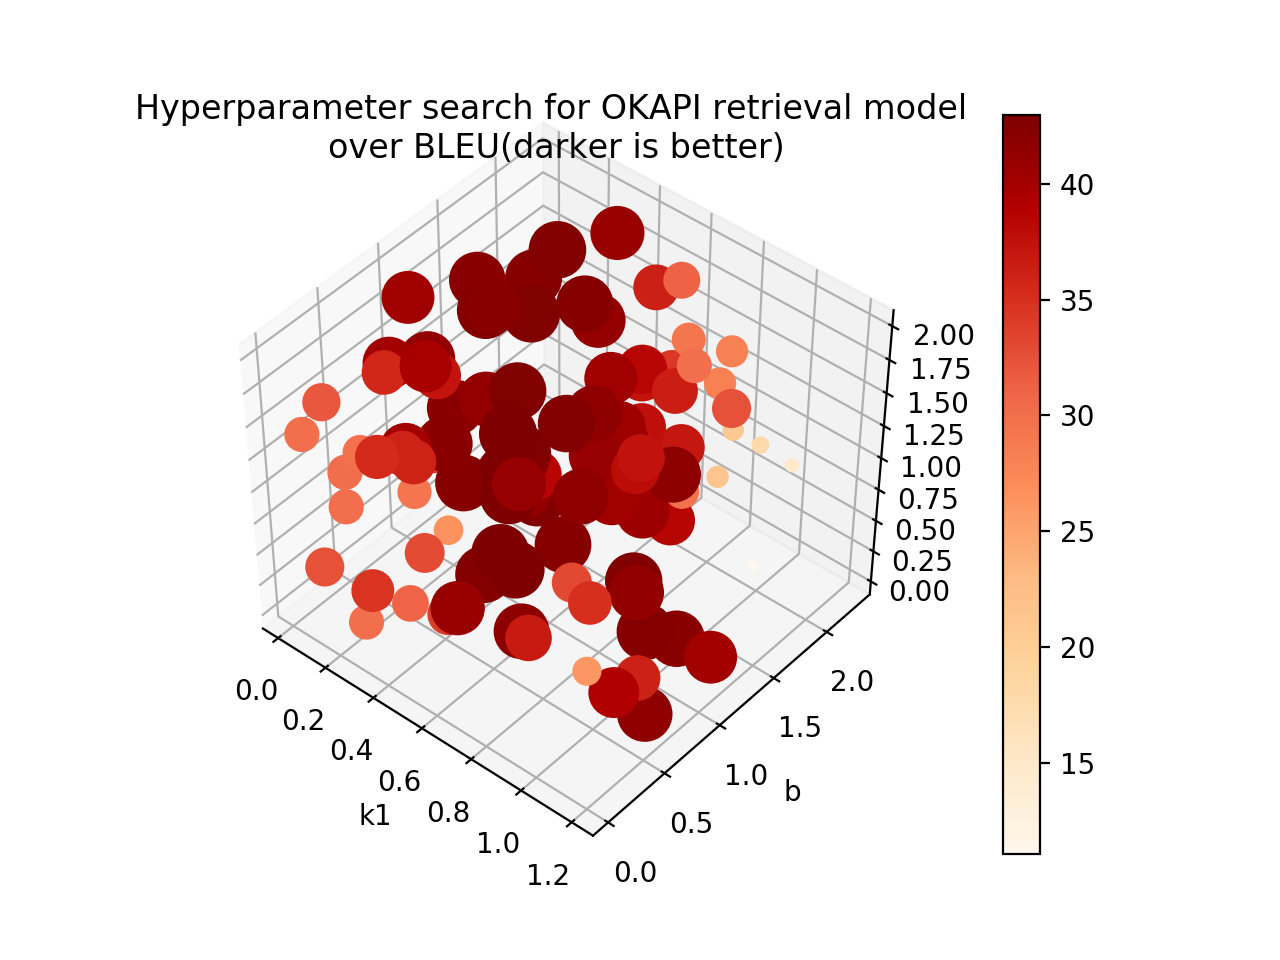

In [98]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# %matplotlib notebook

x, y, z, s, c = [], [], [], [], []
for j in list(task_groups):
    x.append(task_groups[j]["hyps"]["k1"])
    y.append(task_groups[j]["hyps"]["b"])
    z.append(task_groups[j]["hyps"]["k3"])
    s.append(0.005*task_groups[j]["avg_BLEU"]**3)
    c.append(task_groups[j]["avg_BLEU"])

plt.title("Hyperparameter search for OKAPI retrieval model \nover BLEU(darker is better)")
plt.xlabel('k1')
plt.ylabel('b')
# plt.zlabel('k3')
p = ax.scatter(x, y, zs=z, s=s, c=c, alpha=1, cmap="OrRd")
fig.colorbar(p)
plt.show()

In [77]:
for j in list(task_groups):
    print(task_groups[j]["hyps"], "BLEU:", task_groups[j]["avg_BLEU"])

{'k3': 0.5905300654683296, 'k1': 0.8179659186653743, 'b': 2.0314368537488976} BLEU: 21.505764424800873
{'k3': 0.979926257648845, 'k1': 0.8384954453862125, 'b': 1.2956274309436513} BLEU: 40.52932232618332
{'k3': 1.1170500301850437, 'k1': 0.19677445190041523, 'b': 1.05925878800152} BLEU: 42.09034264087677
{'k3': 1.2808935851200074, 'k1': 1.1913488806486114, 'b': 1.7911862785527861} BLEU: 14.790011197328568
{'k3': 1.0418770307367122, 'k1': 0.5102716955636952, 'b': 1.5310919868830293} BLEU: 41.463894844055176
{'k3': 0.6773811803333942, 'k1': 0.06940353925286766, 'b': 1.5930248036046457} BLEU: 41.302419900894165
{'k3': 0.13657410567354544, 'k1': 1.1561756568048707, 'b': 0.6072115694978384} BLEU: 41.61533713340759
{'k3': 0.36907111871683873, 'k1': 0.5046938182792853, 'b': 0.31714897796988856} BLEU: 34.066869020462036
{'k3': 0.782103370238145, 'k1': 0.896878229756698, 'b': 1.4089170326705918} BLEU: 38.507851362228394
{'k3': 1.129585833172715, 'k1': 0.9082520042100403, 'b': 1.938086087225889} 

In [78]:
max([task_groups[j]["avg_BLEU"] for j in list(task_groups)])

42.97430455684662